In [1]:
import tvm
from tvm import relay

import numpy as np

from tvm.contrib.download import download_testdata
import onnx

import torch
import torchvision
from torchvision import transforms

/home/yrx/miniconda3/envs/tvm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from model import edsr_django
model_name = "edsr_baseline_x2-1bc95232"
weight_path = "../models/edsr_baseline_x2-1bc95232.pt"
edsr = edsr_django.EDSR(2)
edsr.load_state_dict(torch.load(weight_path))
edsr = edsr.eval()

#获取TorchScripted模型
input_shape = [1, 3, 224, 224]
input_data = torch.randn(input_shape)
scripted_model = torch.jit.trace(edsr, input_data).eval()

In [3]:
edsr.export_onnx("../models/edsr_baseline_x2-1bc95232.onnx")

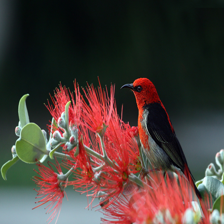

In [21]:
from PIL import Image
img_path = "../test/0853x4.png"
img = Image.open(img_path).resize((224, 224))
img.show()
# my_preprocess = transforms.Compose(
#     [
#         transforms.Resize(256),
#         transforms.CenterCrop(1),
#     ]
# )
img_ycbcr = img.convert("YCbCr") # convert to YCbCr
img_y, img_cb, img_cr  = img_ycbcr.split()
x = np.array(img_y)[np.newaxis, np.newaxis, :, :]
np_img = np.array(img)[np.newaxis, :, :, :]
np_img = np_img.transpose((0, 3, 1, 2))
# a = img.view()
# b = img.view()
# img = np.concatenate((img, a, b), axis=0)

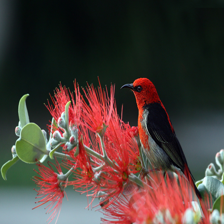

(1, 3, 224, 224)


In [25]:
from PIL import Image
img_path = "../test/0853x4.png"
img = Image.open(img_path).resize((224, 224))
img.show()
img = np.array(img)
img = np.transpose(img, (2, 0, 1))
img = np.array(img)[np.newaxis, :, :, :]
print(img.shape)

In [22]:
np_img.shape

(1, 3, 224, 224)

In [16]:
# onnx_model = onnx.load("../models/edsr_baseline_x2-1bc95232.onnx")
input_name = "input0"
shape_dict = [(input_name, (1, 3, 224, 224))]
mod, params = relay.frontend.from_pytorch(scripted_model, shape_dict)

In [17]:
target = "llvm"
dev = tvm.cpu(0)
with tvm.transform.PassContext(opt_level=1):
    executor = relay.build_module.create_executor(
        "graph", mod, tvm.cpu(0), target, params
    ).evaluate()

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [51]:
from tvm.contrib import graph_executor

dtype = "float32"
# module = graph_executor.GraphModule(lib["default"](dev))
# # 设置输入
# module.set_input(input_name, tvm.nd.array(x.astype(dtype)))
# # 执行
# module.run()
# # 得到输出
# tvm_output = module.get_output(0)
tvm_output = executor(tvm.nd.array(img.astype(dtype))).numpy()

In [53]:
print(out.shape)
new_img = Image.fromarray(out[0].astype(np.uint8))

(1, 448, 448, 3)


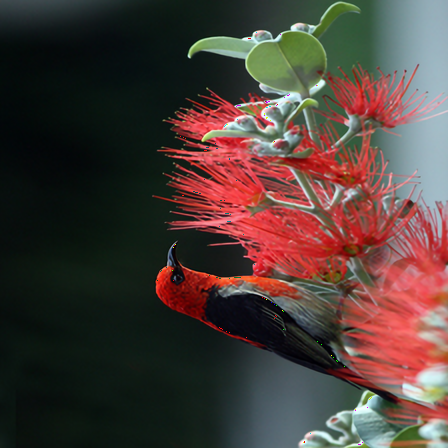

In [54]:
new_img

In [33]:
out_img = Image.fromarray(tvm_output[0].reshape((448, 448, 3)).astype(np.uint8))
for ele in out_img:
    ele.show()

TypeError: 'Image' object is not iterable